# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
import math
import tensorflow as tf
from tqdm import tqdm
import csv

#Load data from pickle file
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
print('Basic setup is done and fine')

Basic setup is done and fine


In [2]:
### To start off let's do a basic data summary.

#Find out number of training examples
n_train = len(train['labels'])

#Find out number of testing examples
n_test = len(test['labels'])

#Find out what's the shape of an image?
image_shape = train['features'][0].shape

#Find out how many classes are in the dataset
n_classes = (np.unique(train['labels'])).size

#Print the found numbers
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print('Basic summary printed')

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Basic summary printed


Showing the the definition of the 43 classes used in the dataset
------------------------------------------------------------------
['ClassId', 'SignName']
['0', 'Speed limit (20km/h)']
['1', 'Speed limit (30km/h)']
['2', 'Speed limit (50km/h)']
['3', 'Speed limit (60km/h)']
['4', 'Speed limit (70km/h)']
['5', 'Speed limit (80km/h)']
['6', 'End of speed limit (80km/h)']
['7', 'Speed limit (100km/h)']
['8', 'Speed limit (120km/h)']
['9', 'No passing']
['10', 'No passing for vechiles over 3.5 metric tons']
['11', 'Right-of-way at the next intersection']
['12', 'Priority road']
['13', 'Yield']
['14', 'Stop']
['15', 'No vechiles']
['16', 'Vechiles over 3.5 metric tons prohibited']
['17', 'No entry']
['18', 'General caution']
['19', 'Dangerous curve to the left']
['20', 'Dangerous curve to the right']
['21', 'Double curve']
['22', 'Bumpy road']
['23', 'Slippery road']
['24', 'Road narrows on the right']
['25', 'Road work']
['26', 'Traffic signals']
['27', 'Pedestrians']
['28', 'Children cro

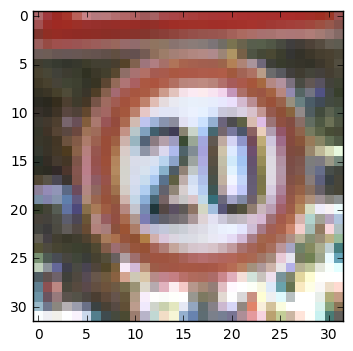

Training picture number 23000 wich has the class: 14 assigned to it. Take a look above which sign is represented by this number


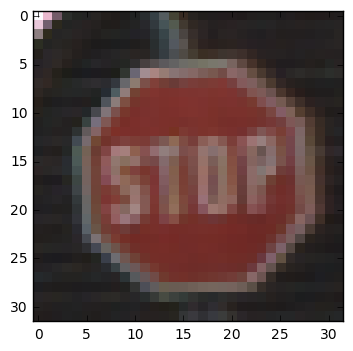

In [14]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

def showclasses_received_from_csv_file():
    with open('signnames.csv', 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONE)
        for row in spamreader:
            print(row)

#Custom function to show rgb image
def imageshow_rgb(input):
    image = np.array(input, dtype=np.uint8)
    plt.imshow(image, interpolation='nearest')
    plt.show()

#Custom function to show gray image
def imageshow_gray(input):
    image = np.array(input, dtype=np.uint8)
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.show()
    
#Custom function to convert RGB image to grayscale. Reason I implemented it from scratch is I can't 
#use opencv in this notebook as it runs in a virtual machine where no opencv is installed
def rgb2gray(rgb):
    r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

print('Showing the the definition of the',n_classes,'classes used in the dataset')
print('------------------------------------------------------------------')
showclasses_received_from_csv_file()
print('------------------------------------------------------------------')
print('Again as reminder these are some specifics about the dataset')
print('------------------------------------------------------------------')
print("Number of images used as training examples =", n_train)
print("Number of images used as testing examples =", n_test)
print("The shape of the image data is =", image_shape)
print('------------------------------------------------------------------')
print('Starting to show some samples of the data')
print('Training picture number 50 wich has the class:',train['labels'][50],'assigned to it. Take a look above which sign is represented by this number')
imageshow_rgb(train['features'][50])
print('Training picture number 23000 wich has the class:',train['labels'][23000],'assigned to it. Take a look above which sign is represented by this number')
imageshow_rgb(train['features'][23000])
#imageshow_gray(train['features'][0])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

#Implement Min-Max scaling for rgb image data
def normalize_rgb(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [a, b]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    #Implement Min-Max scaling for image data per color channel
    a=0.0
    b=1.0
    normalized_image_r = a + (((image_data[:,:,:,0]-0)*(b-a))/(255-0))
    normalized_image_g = a + (((image_data[:,:,:,1]-0)*(b-a))/(255-0))
    normalized_image_b = a + (((image_data[:,:,:,2]-0)*(b-a))/(255-0))
    return normalized_image_r, normalized_image_g, normalized_image_r

#Implement Min-Max scaling for gray image data
def normalize_gray(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [a, b]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    #Implement Min-Max scaling for image data for single gray channel
    a=0.0
    b=1.0
    normalized_image = a + (((image_data-0)*(b-a))/(255-0))
    return normalized_image

#Function to one hot encode the labels as tensorflow can't use the classes 0-42
def one_hot_encode(train_labels, test_labels):
    encoder = LabelBinarizer()
    encoder.fit(train_labels)
    train_labels_one_hot_encoded = encoder.transform(train_labels)
    test_labels_one_hot_encoded = encoder.transform(test_labels)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    train_labels_one_hot_encoded = train_labels_one_hot_encoded.astype(np.float32)
    test_labels_one_hot_encoded = test_labels_one_hot_encoded.astype(np.float32)
    return train_labels_one_hot_encoded, test_labels_one_hot_encoded

#Change features to float32, so it can be used against the variables in TensorFlow, which are float32
train_features = train['features'].astype(np.float32)
test_features = test['features'].astype(np.float32)

#Use normalization and one hot encode function
train_features[:,:,:,0],train_features[:,:,:,1],train_features[:,:,:,2] = normalize_rgb(train_features)
test_features[:,:,:,0],test_features[:,:,:,1],test_features[:,:,:,2] = normalize_rgb(test_features)
train_labels,test_labels=one_hot_encode(train['labels'],test['labels'])

print("Preprocessing data - done")

Preprocessing data - done


In [9]:
#Generate 

# Get randomized datasets for training and validation testsize is 5% of all samples. Training is 95% of all samples
def randomized_validation_training_set(train_features, train_labels):
    train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)
    return train_features, valid_features, train_labels, valid_labels

train_features, valid_features, train_labels, valid_labels = randomized_validation_training_set(train_features, train_labels)

print("Splitting datasets - done")

Splitting datasets - done


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [3]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

#The preprocessing is done as follows:
    #1 - normalize the images = features by dividing each pixel with its maximum value of 255. Additionally the outcome is scaled by paramter a and b but in our case its set to be from 0.0 - 1.0
    #2 - one hot encode the classes = labels of the images so that it can be used in the learning process

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

#The setup for the data sets is done as follows:
    #1 - randomize the data sets so that its made sure that a drawn sample ideally contains all classes and not just one type of class
    #2 - split the training dataset in validation and training set. Validation is 5% of all data. Training is 95% of all data

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

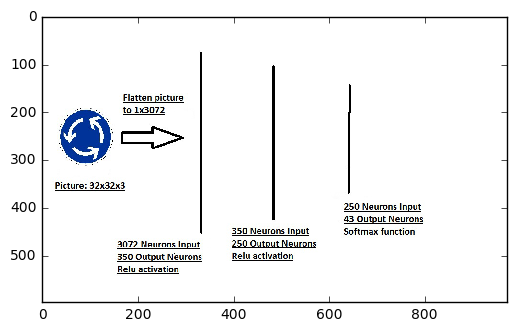

In [6]:
#What is the architecture being chosen:
    #1 - A 2 hidden layer neural network has been chosen
    #2 - The input layers size is 32*32*3=3072 which can be seen in the following code:
         #n_features = 1 
         #for i in range(len(image_shape)):
            #n_features = n_features * image_shape[i]
    #3 - Since all layers are fully connected one needs to flatten the image to a vector in order to feed it to the network. The code for it is:
         #x_flat = tf.reshape(x, [-1, n_features])
    #4 - all layers except the output layer use Relu activation.
    #5 - The output layer has 43 neurons as this is the number of classes which are in the training data set
    #6 - The 1st hidden layer has 350 neurons the 2nd one 250 neurons
    #7 - I started the network with inspiration from the network given here: https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/multilayer_perceptron.py
    #8 - After training I discovered that increasing the neurons in the 1st layer led to better results as well on validation and training accuracy
    #9 - A more elaborate approach with the following architecture could prove to be beneficial: several layers of convolution followed by several classification layers
    #10 - I refrained from using the approach given in #5 due to lack of computing power.
    #11 - Finally see belows picture of the architecture of the neural net:

architecture = mpimg.imread('architecture.jpg')
imageshow_rgb(architecture)

In [10]:
#This is where the model is being setup in tensorflow.

n_features = 1
for i in range(len(image_shape)):
    n_features = n_features * image_shape[i]
n_labels = n_classes
n_hidden_layer_1 = 350
n_hidden_layer_2 = 250

print('Input layer number of neurons', n_features)
print('Hidden layer 1 number of neurons', n_hidden_layer_1)
print('Hidden layer 2 number of neurons', n_hidden_layer_2)
print('Output layer number of neurons', n_labels)

#Set the weights and biases tensors
weights = {
    'hidden_layer_1': tf.Variable(tf.random_normal([n_features, n_hidden_layer_1])),
    'hidden_layer_2': tf.Variable(tf.random_normal([n_hidden_layer_1, n_hidden_layer_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_layer_2, n_labels]))
}

biases = {
    'hidden_layer_1': tf.Variable(tf.random_normal([n_hidden_layer_1])),
    'hidden_layer_2': tf.Variable(tf.random_normal([n_hidden_layer_2])),
    'out': tf.Variable(tf.random_normal([n_labels]))
}

# tf Graph input
x = tf.placeholder("float32", [None, image_shape[0], image_shape[1], image_shape[2]])
y = tf.placeholder("float32", [None, n_labels])

x_flat = tf.reshape(x, [-1, n_features])

# Create model
def multilayer_network(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x_flat, weights['hidden_layer_1']), biases['hidden_layer_1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['hidden_layer_2']), biases['hidden_layer_2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Construct model
prediction = multilayer_network(x, weights, biases)

#The accuracy measured against the test and validation set
test_accuracy = 0.0
validation_accuracy = 0.0

# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
print('Accuracy function created.')
print('Network setup correctly')

Input layer number of neurons 3072
Hidden layer 1 number of neurons 350
Hidden layer 2 number of neurons 250
Output layer number of neurons 43
Accuracy function created.
Network setup correctly


Number of training samples 37248
Training setup done
Training starting......


Epoch  1/20: 100%|██████████| 373/373 [03:34<00:00,  7.58batches/s]


Training for epoch 1 done


Epoch  2/20: 100%|██████████| 373/373 [03:09<00:00,  1.97batches/s]


Training for epoch 2 done


Epoch  3/20: 100%|██████████| 373/373 [03:42<00:00,  1.68batches/s]


Training for epoch 3 done


Epoch  4/20: 100%|██████████| 373/373 [03:23<00:00,  1.83batches/s]


Training for epoch 4 done


Epoch  5/20: 100%|██████████| 373/373 [03:21<00:00,  1.85batches/s]


Training for epoch 5 done


Epoch  6/20: 100%|██████████| 373/373 [03:34<00:00,  7.24batches/s]


Training for epoch 6 done


Epoch  7/20: 100%|██████████| 373/373 [03:19<00:00,  7.72batches/s]


Training for epoch 7 done


Epoch  8/20: 100%|██████████| 373/373 [02:57<00:00,  2.10batches/s]


Training for epoch 8 done


Epoch  9/20: 100%|██████████| 373/373 [03:02<00:00,  7.31batches/s]


Training for epoch 9 done


Epoch 10/20: 100%|██████████| 373/373 [02:58<00:00,  8.70batches/s]


Training for epoch 10 done


Epoch 11/20: 100%|██████████| 373/373 [02:54<00:00,  2.13batches/s]


Training for epoch 11 done


Epoch 12/20: 100%|██████████| 373/373 [03:01<00:00,  7.45batches/s]


Training for epoch 12 done


Epoch 13/20: 100%|██████████| 373/373 [02:56<00:00,  7.68batches/s]


Training for epoch 13 done


Epoch 14/20: 100%|██████████| 373/373 [02:49<00:00,  2.20batches/s]


Training for epoch 14 done


Epoch 15/20: 100%|██████████| 373/373 [02:46<00:00,  2.24batches/s]


Training for epoch 15 done


Epoch 16/20: 100%|██████████| 373/373 [02:45<00:00,  2.25batches/s]


Training for epoch 16 done


Epoch 17/20: 100%|██████████| 373/373 [02:55<00:00,  2.12batches/s]


Training for epoch 17 done


Epoch 18/20: 100%|██████████| 373/373 [02:48<00:00,  2.22batches/s]


Training for epoch 18 done


Epoch 19/20: 100%|██████████| 373/373 [03:00<00:00,  8.32batches/s]


Training for epoch 19 done


Epoch 20/20: 100%|██████████| 373/373 [02:45<00:00,  2.25batches/s]


Training for epoch 20 done
------------------------
Model saved in file: /tmp/model.ckpt
------------------------
training has finished now for the results


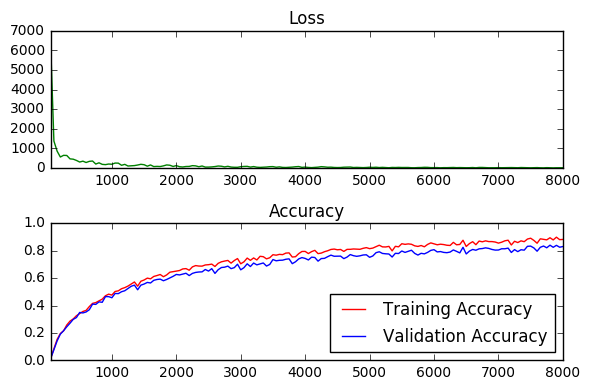

Validation accuracy at 0.8383477926254272
Test accuracy at 0.6938242316246033


In [8]:
#This is where the model is being trained 

# Parameters
learning_rate = 0.001
training_epochs = 20
batch_size = 100
n_train_samples = len(train_features)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(prediction, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

print('Number of training samples', n_train_samples)
print('Training setup done')
print('Training starting......')

# Feed dicts for training, validation, and test session
train_feed_dict = {x: train_features, y: train_labels}
valid_feed_dict = {x: valid_features, y: valid_labels}
test_feed_dict = {x: test_features, y: test_labels}

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil((n_train_samples)/batch_size))

    for epoch_i in range(training_epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, training_epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, cost],
                feed_dict={x: batch_features, y: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)
                
        print('Training for epoch',(epoch_i+1),'done')
        
        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
        
        # Check accuracy against Test data
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)
        
        if(epoch_i+1 == training_epochs):
            save_path = saver.save(session, '/tmp/model.ckpt')
            print("------------------------")
            print("Model saved in file: %s" % save_path)
            print("------------------------")

#Print results of accuracy
print('training has finished now for the results')
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))
print('Test accuracy at {}'.format(test_accuracy))

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

In [ ]:
#What where the parematers being chosen for training:
    #1 - I used an Adamoptimizer which is using momentum and converting faster which is benefecial as on my machine training the network currently takes about 1 hour.
    #2 - I started with the hyper parameters with inspiration from the network given here: https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/multilayer_perceptron.py
    #3 - After training I discovered that increasing epochs led to better results as well on validation and training accuracy
    #4 - I ended up using: learning_rate = 0.001, training_epochs = 20, batch_size = 100
    #5 - I refrained from using regularization or dropout as overfitting was not yet seen as an issue with the training and validation accuracy where the are currently.
    #6 - If using a more complex structure e.g several layers of convolution followed by several classification layers regularization or dropout could become vital in order to avoid overfitting.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

In [ ]:
#What was the approach taken overall:
    #1 - I studied some examples of similar problems
    #2 - I ended up starting from the architecture of a similar problem I found in the examples
    #3 - Once being equipped with a starting point I used an iterative approach training the network several times with different parameters. Changing only 1 parameter at the time.
    #4 - A change in parameters was considered successfully if as well validation, training and test accuracy increased at least 1%
    #5 - I am entirely sure more work can be done on the hyper paramters leading to a results over 95% in test accuracy. But its hard to do that on a slow machine where 1 training takes 1 hour.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Setting up these image for test
------------
Test Image 1: Class: 33,Turn right ahead


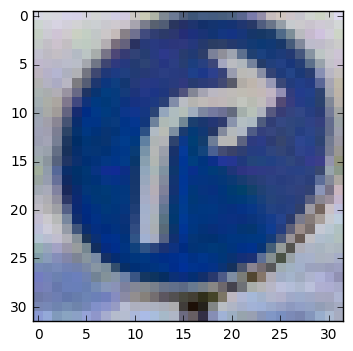

Test Image 2: Class: 25,Road work


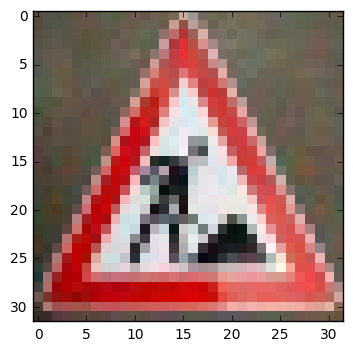

Test Image 3: Class: 14,Stop


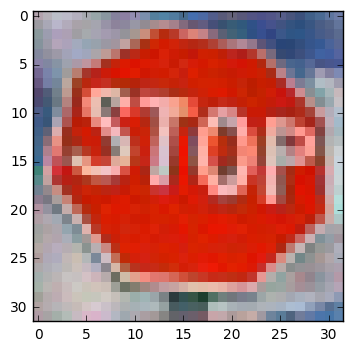

Test Image 4: Class: 19,Dangerous curve to the left


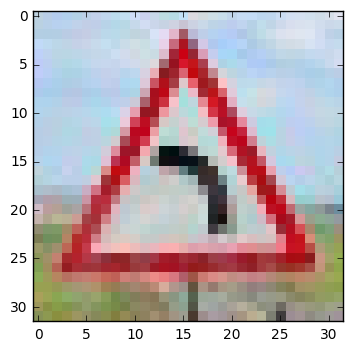

Test Image 5: Class: 13,Yield


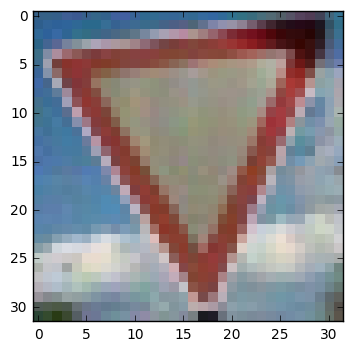

Test Image 6: Class: 8,Speed limit (120km/h)


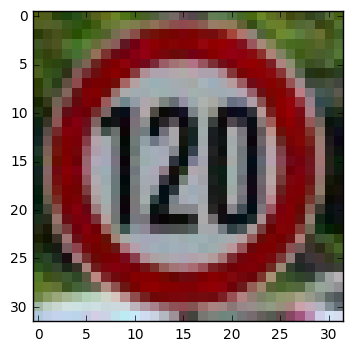

Test Images setup done


In [9]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

#Load the images from local machine
image1 = mpimg.imread('test_images/Test_picture_1.jpg')
image2 = mpimg.imread('test_images/Test_picture_2.jpg')
image3 = mpimg.imread('test_images/Test_picture_3.jpg')
image4 = mpimg.imread('test_images/Test_picture_4.jpg')
image5 = mpimg.imread('test_images/Test_picture_5.jpg')
image6 = mpimg.imread('test_images/Test_picture_6.jpg')

print('Setting up these image for test')
print('------------')

#Print the images and create and print their according labels
test_images_labels = np.zeros(shape=(6,43), dtype=np.float32)
print('Test Image 1: Class: 33,Turn right ahead')
test_images_labels[0][33]=1.0
imageshow_rgb(image1)
print('Test Image 2: Class: 25,Road work')
test_images_labels[1][25]=1.0
imageshow_rgb(image2)
print('Test Image 3: Class: 14,Stop')
test_images_labels[2][14]=1.0
imageshow_rgb(image3)
print('Test Image 4: Class: 19,Dangerous curve to the left')
test_images_labels[3][19]=1.0
imageshow_rgb(image4)
print('Test Image 5: Class: 13,Yield')
test_images_labels[4][13]=1.0
imageshow_rgb(image5)
print('Test Image 6: Class: 8,Speed limit (120km/h)')
test_images_labels[5][8]=1.0
imageshow_rgb(image6)

#Create the features to feed the network
test_images_features = np.zeros(shape=(6,32,32,3), dtype=np.float32)
test_images_features[0:,:,:] = image1.astype(np.float32)
test_images_features[1:,:,:] = image2.astype(np.float32)
test_images_features[2:,:,:] = image3.astype(np.float32)
test_images_features[3:,:,:] = image4.astype(np.float32)
test_images_features[4:,:,:] = image5.astype(np.float32)
test_images_features[5:,:,:] = image6.astype(np.float32)
test_images_features[:,:,:,0],test_images_features[:,:,:,1],test_images_features[:,:,:,2] = normalize_rgb(test_images_features)

print('Test Images setup done')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [8]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

#What could make predictions hard:
#1 - the pictures given above have been prepared by me particularily to be fed into the network. 
    # This already has eliminated some of the difficulties that can occur. But some still persist
#2 - In general I could see the following problems occuring:
    # Two or more traffic signs in 1 picture which would lead to not knowing anymore what is the traffic sign to be classified
    # I did not use convolution layers meaning the position of the traffic sign in the picture unfortunately is going to matter. Meaning whether the traffic sign is centered or not is going to matter
    # Especially for the last picture = picture 6 its going to be quite hard to distuingish from other speed limits or signs without characters that have the same shape and color. The differences are simply pretty small
    # Picture 4 could potentially be very hard to interprete since its got quite some background with a horizon meaning there is land and sky parts in the picture. In general background is a problem since all pixels are fed to the network.
    # If a picture is taken by another camera the lighting and resolution could be quite different which will certainly cause difficulties if the training set has been taken by just 1 camera.
    # Picture 1 has the blue color as unique feature which should really stand out and should make classification easier
    # Picture 2 has a very well structure background which should make classification a bit easier even though its harder to distuingish because the shape and color is quite common with other traffic signs
    # Picture 3 has its shape stand out and a well structured background so it should make classification easier
    # Picture 5 also has its shape stand out and a well structured background so it should make classification easier

In [35]:
#Run the predictions and evaluate accuracy plus additional insight in results

#Add ops to save and restore all the variables.
saver = tf.train.Saver()

#Setting up the measurements needed for evaluating the accuracy
image_accuracy = 0.0
image_feed_dict = {x: test_images_features, y: test_images_labels}
softmaxprobabilities = np.zeros(shape=(6,43), dtype=np.uint8)
prediction2 = tf.nn.softmax(multilayer_network(x, weights, biases))
topFiver_prediction = tf.nn.in_top_k(prediction2, tf.argmax(y, 1), 5)

#Now, launch the model, use the saver to restore variables from disk, 
#and evaluate the accuracy with the model.
with tf.Session() as sess:
    #Restore variables from disk.
    saver.restore(sess, "/tmp/model.ckpt")
    print("Model restored. Now start the predictions")
    #Check accuracy against Validation data
    image_accuracy = sess.run(accuracy, feed_dict=image_feed_dict)
    print('Image accuracy at {}'.format(image_accuracy))
    #Get the softmax probabilities
    softmaxprobabilities = (sess.run(prediction2, feed_dict=image_feed_dict))
    #Get information whether the correct class is within the top five predictions
    topfiveprediction = sess.run(topFiver_prediction, feed_dict=image_feed_dict)
    #Print the results of the classes predicted by evaluating the nonzero elements of the softmax probabilities
    print('-----------------')
    print('classes searched are:')
    print('Test Image 1: Class: 33,Turn right ahead')
    print('Test Image 2: Class: 25,Road work')
    print('Test Image 3: Class: 14,Stop')
    print('Test Image 4: Class: 19,Dangerous curve to the left')
    print('Test Image 5: Class: 13,Yield')
    print('Test Image 6: Class: 8,Speed limit (120km/h)')
    print('-----------------')
    print('classed predicted are:')
    print('Test Image 1: Class:',np.nonzero(softmaxprobabilities[0])[0])
    print('Test Image 2: Class:',np.nonzero(softmaxprobabilities[1])[0])
    print('Test Image 3: Class:',np.nonzero(softmaxprobabilities[2])[0])
    print('Test Image 4: Class:',np.nonzero(softmaxprobabilities[3])[0])
    print('Test Image 5: Class:',np.nonzero(softmaxprobabilities[4])[0])
    print('Test Image 6: Class:',np.nonzero(softmaxprobabilities[5])[0])
    print('-----------------')
    #Print the softmax probabilities
    print('The softmax probabilities are:')
    print(softmaxprobabilities)
    print('-----------------')
    #Print the info whether searched for class is in top five predictions
    print('Is the picture label in the top five probabilities?:')
    print(topfiveprediction)

Model restored. Now start the predictions
Image accuracy at 0.6666666865348816
-----------------
classes searched are:
Test Image 1: Class: 33,Turn right ahead
Test Image 2: Class: 25,Road work
Test Image 3: Class: 14,Stop
Test Image 4: Class: 19,Dangerous curve to the left
Test Image 5: Class: 13,Yield
Test Image 6: Class: 8,Speed limit (120km/h)
-----------------
classed predicted are:
Test Image 1: Class: [33]
Test Image 2: Class: [25]
Test Image 3: Class: [14]
Test Image 4: Class: [ 0 19]
Test Image 5: Class: [13]
Test Image 6: Class: [ 1 35]
-----------------
The softmax probabilities are:
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
#It is not performing equally compared to the validation accuracy which is in many ways not surprising. 
#In the case shown it is nearly performing as well as the test accuracy from the test set which was 69% 
#However I tried this several times and sometimes the performance was as low as only 2 out of 6 correctly marked pictures when the network was trained again. 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

In [ ]:
#Image 1,2,3,5 are very certain
#Image 4,6 are very uncertain
#When calling topFiver_prediction = tf.nn.in_top_k(prediction2, tf.argmax(y, 1), 5) it comes back as true meaning the correct classes should be in the top five predictions

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.